# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [51]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime as dt

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline
# plt.rcParams['font.size'] = 18

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

# Functions

In [3]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [4]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 100]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
decep = [3, 246, 247, 309, 20]

In [5]:
def JRFluxCS(lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    vmax = .12/sum(transports)
    
    H, xedges, yedges = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)

    #maybe get rid of the lines? - the divide by numbers feel rather arbitrary but the best solution i can think of
    #not quatifying based on figs so i think fine
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cm.speed)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax * sum(transports)).values),2)]) 
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_ylabel('Depth [m]')
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

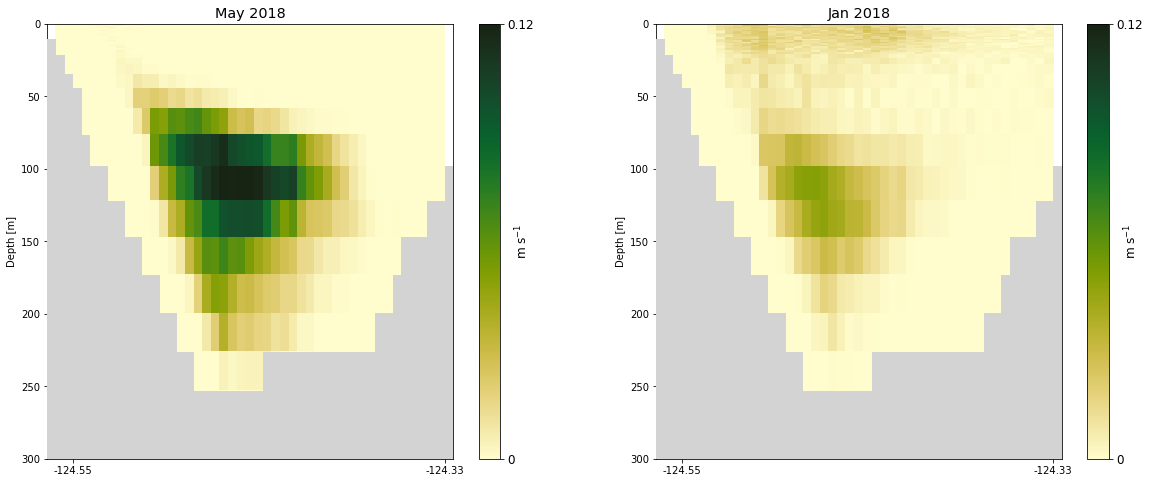

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
plt.rcParams['font.size'] = 12

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS(18, 63, 377, 300, ax[0], "May 2018")

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRFluxCS(18, 63, 377, 300, ax[1], "Jan 2018")

In [7]:
# get data for winter 2016/17
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
jan_start = 1
mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
time = (mar_end - jan_start + 1) + (dec_end - oct_start + 1) # need to deivide by the FULL timespan you're looking at

transport1 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport2 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time
lon2 =  mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]
depth2 =  mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]

tranW16 = np.append(transport1, transport2)
lonW16 = np.append(lon1,lon2)
depthW16 = np.append(depth1,depth2)

In [8]:
# get data for winter 2017/18

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport1 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

months = ['jan', 'feb', 'mar']
files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+month+'18/ariane_positions_quantitative.nc' for month in months]
transport2 = []
lon2 = []
depth2 = []

for file in files:
    mydata = xr.open_dataset(file)
    transport2 = np.append(transport2, mydata.init_transp[(mydata.final_section != 0)]/time)
    lon2 = np.append(lon2, mydata['init_lon'][(mydata.final_section != 0)])
    depth2 = np.append(depth2, mydata['init_depth'][(mydata.final_section != 0)])
    
tranW17 = np.append(transport1, transport2)
lonW17 = np.append(lon1, lon2)
depthW17 = np.append(depth1, depth2)

In [9]:
# get data for summer 2017

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
time = sep_end - apr_start +1

# tempS17 = mydata['init_temp'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
# saltS17 = mydata['init_salt'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
tranS17 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
lonS17 = mydata['init_lon'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
depthS17 = mydata['init_depth'][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]

In [10]:
def JRFluxSeason(lonW, lonE, figrid, maxdepth, ax, lons, transports, depths):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    
    vmax = .12/sum(transports)
    
    H, xedges, yedges = np.histogram2d(dist, depths*-1, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)

#     maybe get rid of the lines? - the divide by numbers feel rather arbitrary but the best solution i can think of
#     not quatifying based on figs so i think fine
    h= H
    h[11,:] = H[11,:]/2.2
    h[19,:] = H[19,:]/2.3
    h[28,:] = H[28,:]/2
    h[36,:] = H[36,:]/2

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, h.T, vmax = vmax, vmin = 0, cmap=cm.speed)
#     im = ax.pcolormesh(X, Y, H.T, vmax = vmax, vmin = 0, cmap=cm.speed)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax * sum(transports)).values),2)]) 
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_ylabel('Depth [m]')
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))

In [11]:
igrid = 377-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]

In [12]:
lonW = 18
lonE=63

t_lons = mymesh.glamt[0, igrid]
m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
t_dist = t_lons/m2lon
t_depths = mymesh.gdept_1d[0,:]

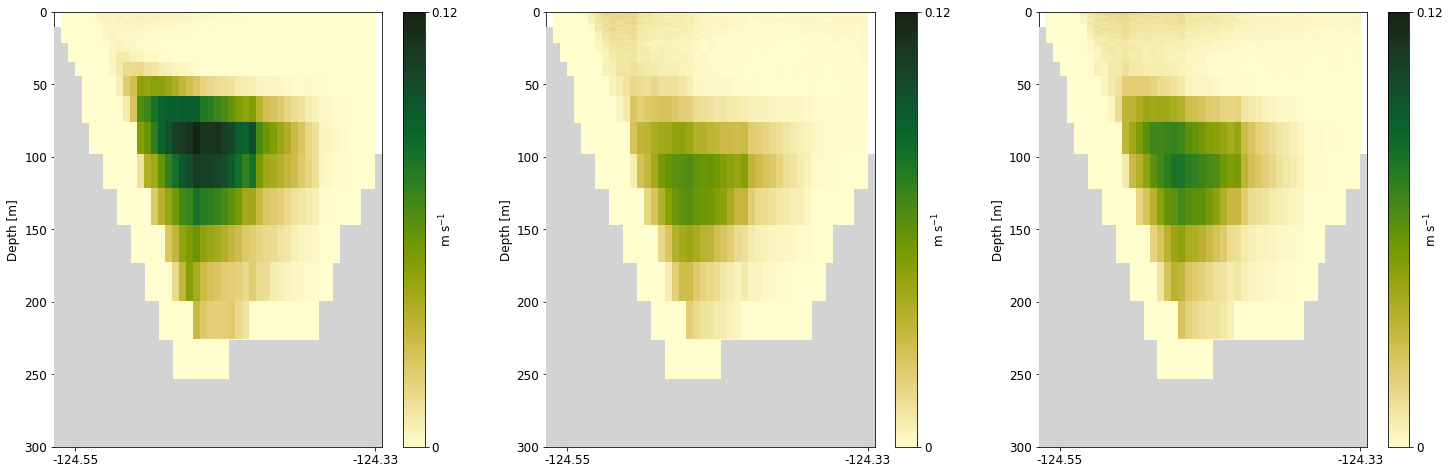

In [13]:
fig, ax = plt.subplots(1,3,figsize=(25,8))
plt.rcParams['font.size'] = 12

JRFluxSeason(18, 63, 377, 300, ax[0], lonS17, tranS17, depthS17)
JRFluxSeason(18, 63, 377, 300, ax[1], xr.DataArray(lonW16), xr.DataArray(tranW16), xr.DataArray(depthW16))
JRFluxSeason(18, 63, 377, 300, ax[2], xr.DataArray(lonW17), xr.DataArray(tranW17), xr.DataArray(depthW17))

### lets see how much gets deeper into the Salish - same plots again but includng meander this time

In [14]:
# get data for winter 2016/17
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

time = (mar_end - jan_start + 1) + (dec_end - oct_start + 1) # need to deivide by the FULL timespan you're looking at

transport1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport2 = mydata.init_transp[(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time
lon2 =  mydata['init_lon'][(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]
depth2 =  mydata['init_depth'][(mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]

MtranW16 = np.append(transport1, transport2)
MlonW16 = np.append(lon1,lon2)
MdepthW16 = np.append(depth1,depth2)

In [15]:
# get data for winter 2017/18

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

transport1 = mydata.init_transp[(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time
lon1 =  mydata['init_lon'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]
depth1 =  mydata['init_depth'][(mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

months = ['jan', 'feb', 'mar']
files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+month+'18/ariane_positions_quantitative.nc' for month in months]
transport2 = []
lon2 = []
depth2 = []

for file in files:
    mydata = xr.open_dataset(file)
    transport2 = np.append(transport2, mydata.init_transp/time)
    lon2 = np.append(lon2, mydata['init_lon'])
    depth2 = np.append(depth2, mydata['init_depth'])
    
MtranW17 = np.append(transport1, transport2)
MlonW17 = np.append(lon1, lon2)
MdepthW17 = np.append(depth1, depth2)

In [16]:
# get data for summer 2017

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
time = sep_end - apr_start +1

# tempS17 = mydata['init_temp'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
# saltS17 = mydata['init_salt'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
MtranS17 = mydata.init_transp[(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
MlonS17 = mydata['init_lon'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
MdepthS17 = mydata['init_depth'][(mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]

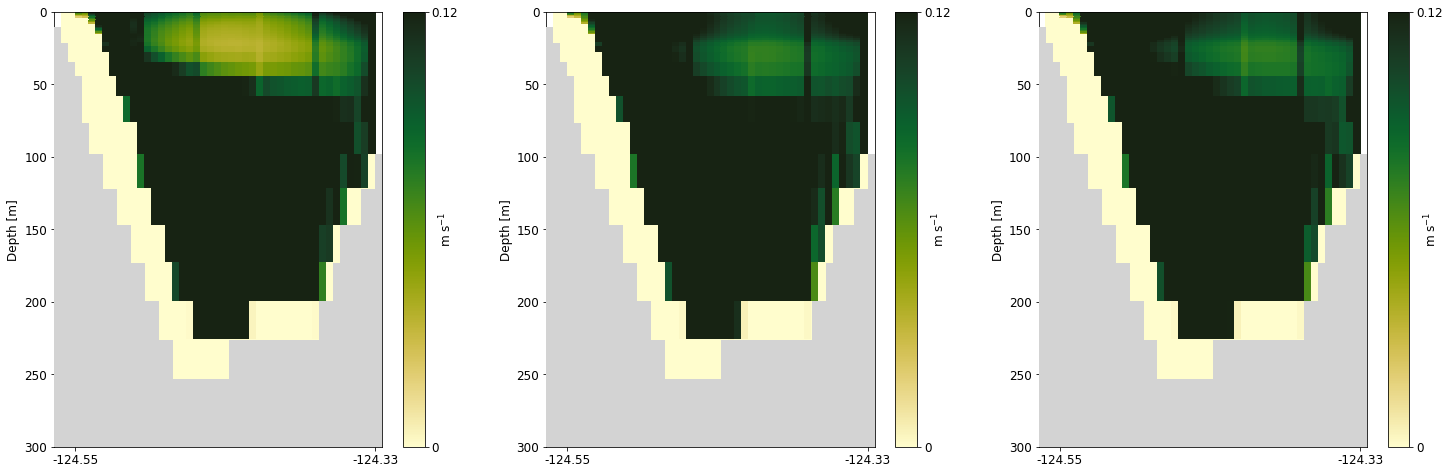

In [17]:
fig, ax = plt.subplots(1,3,figsize=(25,8))
plt.rcParams['font.size'] = 12

JRFluxSeason(18, 63, 377, 300, ax[0], MlonS17, MtranS17, MdepthS17)
JRFluxSeason(18, 63, 377, 300, ax[1], xr.DataArray(MlonW16), xr.DataArray(MtranW16), xr.DataArray(MdepthW16))
JRFluxSeason(18, 63, 377, 300, ax[2], xr.DataArray(MlonW17), xr.DataArray(MtranW17), xr.DataArray(MdepthW17))

In [37]:
# clearly most of the inflow is meander
print(f"percentage of flow that gets deeper in the winter of 2016/17 = {np.sum(tranW16)/np.sum(MtranW16)*100}")
print(f"percentage of flow that gets deeper in the summer of 2017 = {np.sum(tranS17)/np.sum(MtranS17)*100}")
print(f"percentage of flow that gets deeper in the winter of 2017/18 = {np.sum(tranW17)/np.sum(MtranW17)*100}")

percentage of flow that gets deeper in the winter of 2016/17 = 8.73136046790037
percentage of flow that gets deeper in the summer of 2017 = <xarray.DataArray 'init_transp' ()>
array(16.35887923)
percentage of flow that gets deeper in the winter of 2017/18 = 10.461871468414438


In [44]:
# DEPTH OF INFLOW MATTERS
# deep (>50 m)
print(f"deeper than 50 m inflow, percentage that gets inland in the winter of 2016/17 = {np.sum(np.where(depthW16 < -50, tranW16, 0))/np.sum(np.where(MdepthW16 < -50, MtranW16, 0))*100}")
print(f"deeper than 50 m inflow, percentage that gets inland in the summer of 2017 = {np.sum(np.where(depthS17 < -50, tranS17, 0))/np.sum(np.where(MdepthS17 < -50, MtranS17, 0))*100}")
print(f"deeper than 50 m inflow, percentage that gets inland in the winter of 2017/18 = {np.sum(np.where(depthW17 < -50, tranW17, 0))/np.sum(np.where(MdepthW17 < -50, MtranW17, 0))*100}")

deeper than 50 m inflow, percentage that gets inland in the winter of 2016/17 = 11.06888020422083
deeper than 50 m inflow, percentage that gets inland in the summer of 2017 = 20.007143160496526
deeper than 50 m inflow, percentage that gets inland in the winter of 2017/18 = 13.076415281105938


In [45]:
# shallow (<=50 m)
print(f"shallower than 50 m inflow, percentage that gets inland in the winter of 2016/17 = {np.sum(np.where(depthW16 >= -50, tranW16, 0))/np.sum(np.where(MdepthW16 >= -50, MtranW16, 0))*100}")
print(f"shallower than 50 m inflow, percentage that gets inland in the summer of 2017 = {np.sum(np.where(depthS17 >= -50, tranS17, 0))/np.sum(np.where(MdepthS17 >= -50, MtranS17, 0))*100}")
print(f"shallower than 50 m inflow, percentage that gets inland in the winter of 2017/18 = {np.sum(np.where(depthW17 >= -50, tranW17, 0))/np.sum(np.where(MdepthW17 >= -50, MtranW17, 0))*100}")

shallower than 50 m inflow, percentage that gets inland in the winter of 2016/17 = 2.729608146158204
shallower than 50 m inflow, percentage that gets inland in the summer of 2017 = 2.874192552028505
shallower than 50 m inflow, percentage that gets inland in the winter of 2017/18 = 3.3101790359382717


In [58]:
# i think useful to make a timeseries of percentage of inflow that goes inland over time for the CIOPS time-period i'm looking at
def get_data_all(mydata, starttime, endtime):
    depths = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
    return depths, transports

def get_data_no_meander(mydata, starttime, endtime):
    depths = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(endtime-starttime+1)
    return depths, transports

In [66]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720

tranTOP = np.array([])
tranBOT = np.array([])
MtranTOP = np.array([])
MtranBOT = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        tempD, tempT= get_data_no_meander(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        MtempD, MtempT= get_data_all(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
                
        tranTOP = np.append(tranTOP, np.sum(np.where(tempD <= 50, tempT, 0)))
        tranBOT = np.append(tranBOT, np.sum(np.where(tempD > 50, tempT, 0)))
        MtranTOP = np.append(MtranTOP, np.sum(np.where(MtempD <= 50, MtempT, 0)))
        MtranBOT = np.append(MtranBOT, np.sum(np.where(MtempD > 50, MtempT, 0)))

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        MtempD = depthf(mydata.init_z -1.)[0]
        MtempT = mydata.init_transp/time
            
        tempD = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
        tempT = mydata.init_transp[(mydata.final_section != 0)]/time
            
        tranTOP = np.append(tranTOP, np.sum(np.where(tempD <= 50, tempT, 0)))
        tranBOT = np.append(tranBOT, np.sum(np.where(tempD > 50, tempT, 0)))
        MtranTOP = np.append(MtranTOP, np.sum(np.where(MtempD <= 50, MtempT, 0)))
        MtranBOT = np.append(MtranBOT, np.sum(np.where(MtempD > 50, MtempT, 0)))
            

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    tempD, tempT= get_data_no_meander(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
    MtempD, MtempT= get_data_all(mydata, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
                
    tranTOP = np.append(tranTOP, np.sum(np.where(tempD <= 50, tempT, 0)))
    tranBOT = np.append(tranBOT, np.sum(np.where(tempD > 50, tempT, 0)))
    MtranTOP = np.append(MtranTOP, np.sum(np.where(MtempD <= 50, MtempT, 0)))
    MtranBOT = np.append(MtranBOT, np.sum(np.where(MtempD > 50, MtempT, 0)))

In [67]:
dates = np.array([dt.datetime(2016,1,1)+relativedelta(months=i) for i in range(12*5)])

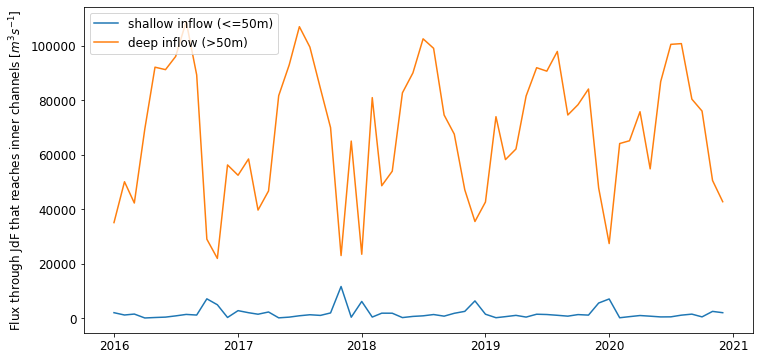

In [68]:
# first lets just look at how much is coming shallow versus at depth over the time-period
fig, ax = plt.subplots(1,1, figsize=[12,6])

ax.plot(dates,tranTOP,label='shallow inflow (<=50m)')
ax.plot(dates,tranBOT,label='deep inflow (>50m)')
ax.set_ylabel('Flux through JdF that reaches inner channels [$m^3 s^{-1}$]')
ax.legend();

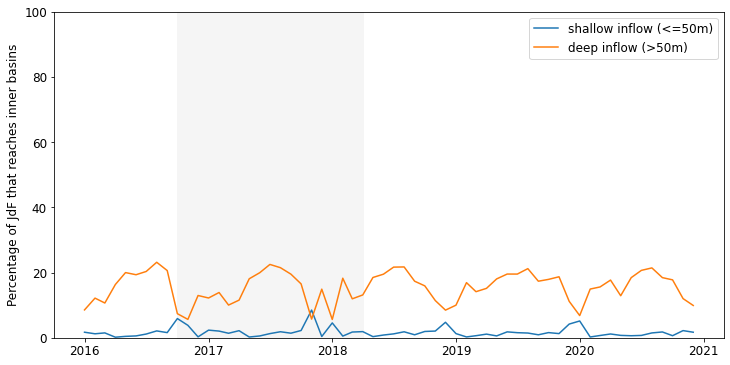

In [69]:
# first lets just look at how much is coming shallow versus at depth over the time-period
fig, ax = plt.subplots(1,1, figsize=[12,6])

ax.plot(dates,(tranTOP/MtranTOP)*100,label='shallow inflow (<=50m)')
ax.plot(dates,(tranBOT/MtranBOT)*100,label='deep inflow (>50m)')
ax.set_ylabel('Percentage of JdF that reaches inner basins')
ax.fill_between(dates, 0, 100, where=(dates<dates[27+1])&(dates>=dates[9]), color='whitesmoke')
ax.set_ylim([0,100])

ax.legend();

In [34]:
def JRTracerFluxCS(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'salt':
            t_max = round(34 * 0.1,1)
            cmap = cm.haline
        else:
            t_max = round(45 * 0.1,1)
            cmap = cm.matter
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'nitrate':
            t_max = round(30 * 0.1,1)
            cmap = cm.rain
        else:
            t_max = round(2200 * 0.1,1)
            cmap = cm.turbid
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label('g kg-1 m s-1', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

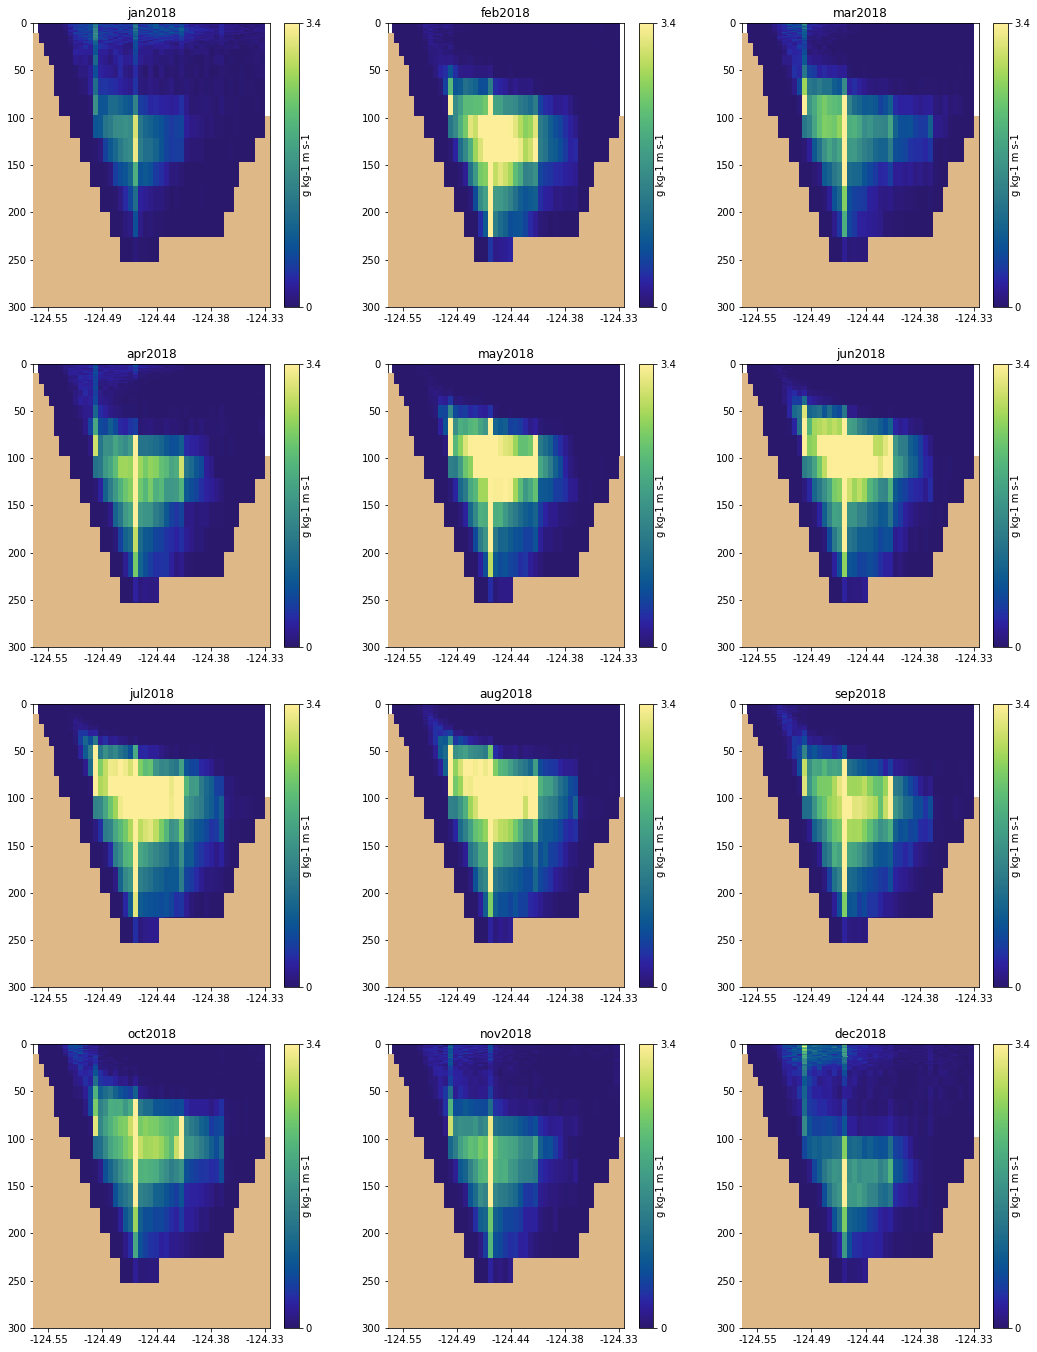

In [7]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    #in the format [tracer, jgridW, jgridE, figrid, maxdepth, ax, title]
    JRTracerFluxCS('salt', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

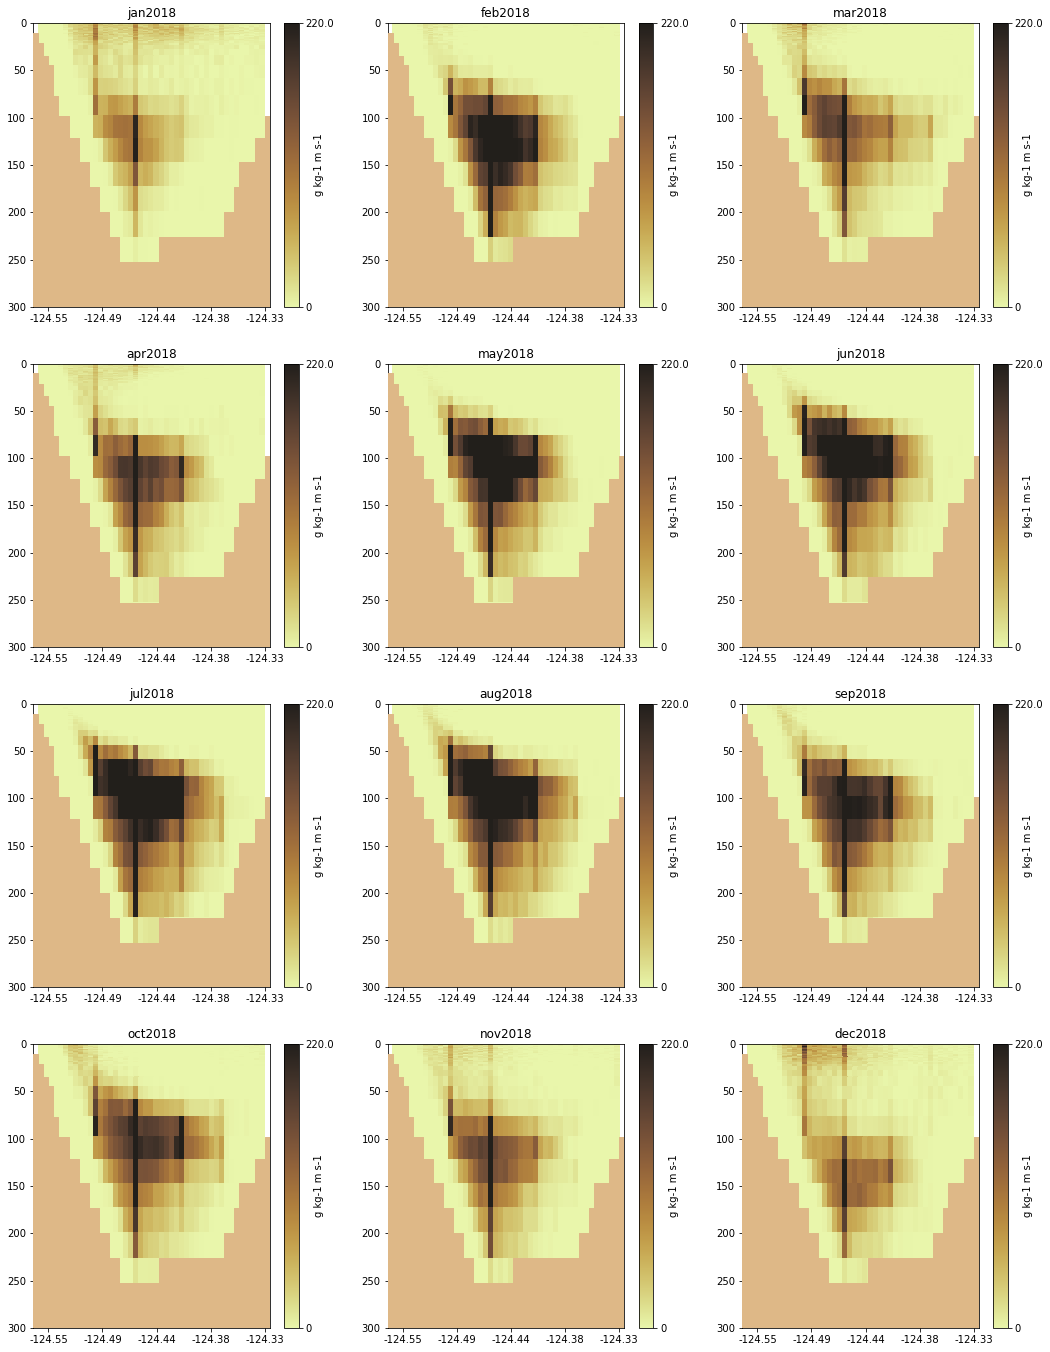

In [8]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    JRTracerFluxCS('carbon', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

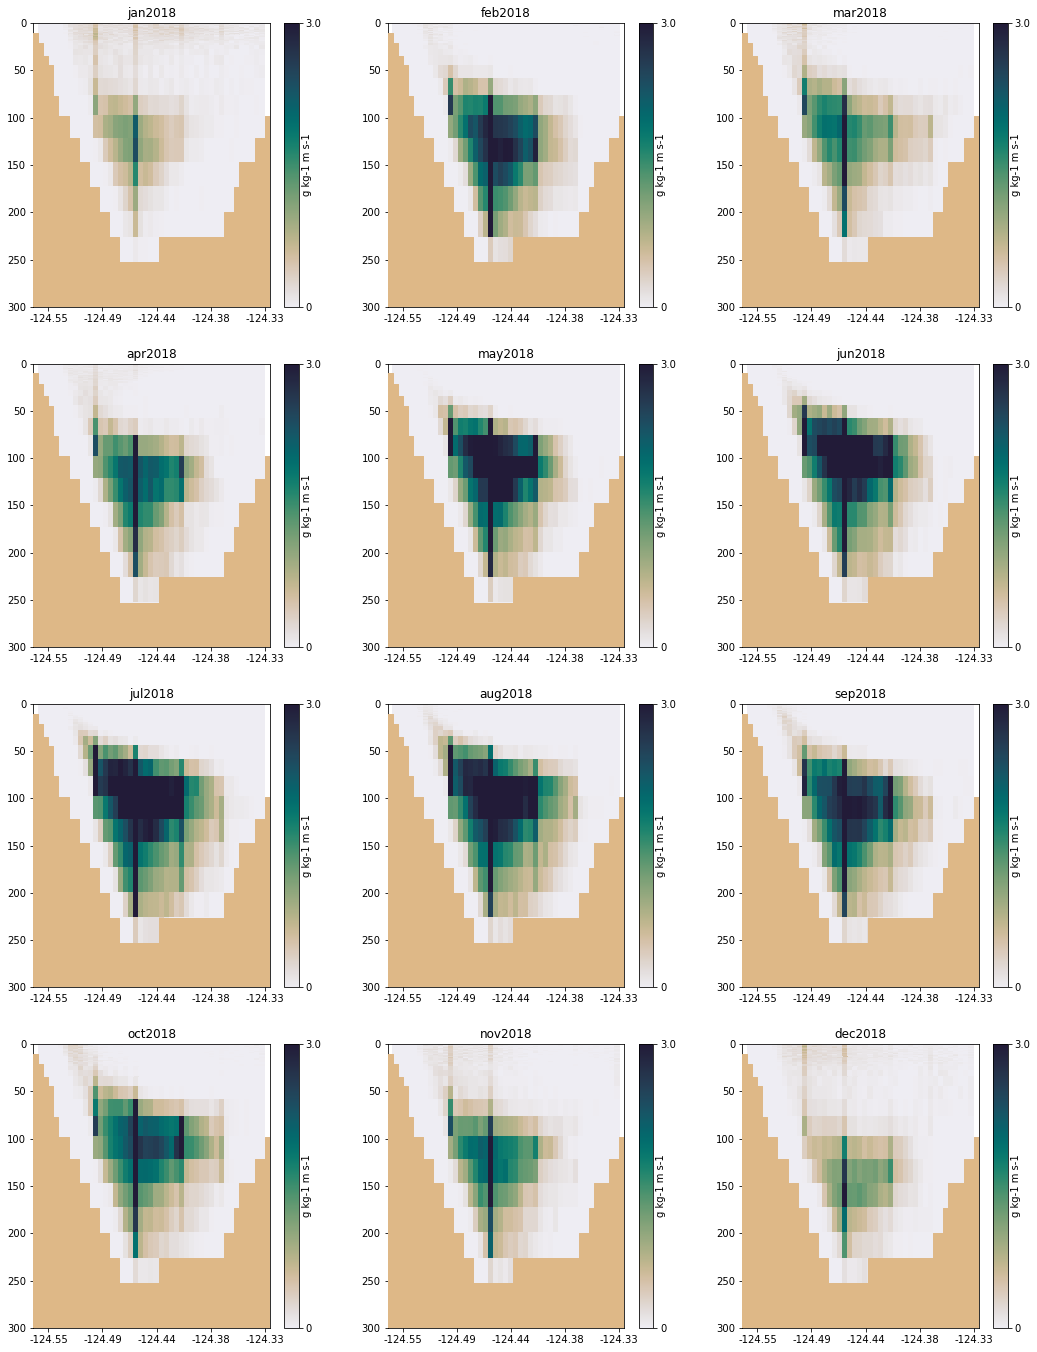

In [9]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    JRTracerFluxCS('nitrate', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

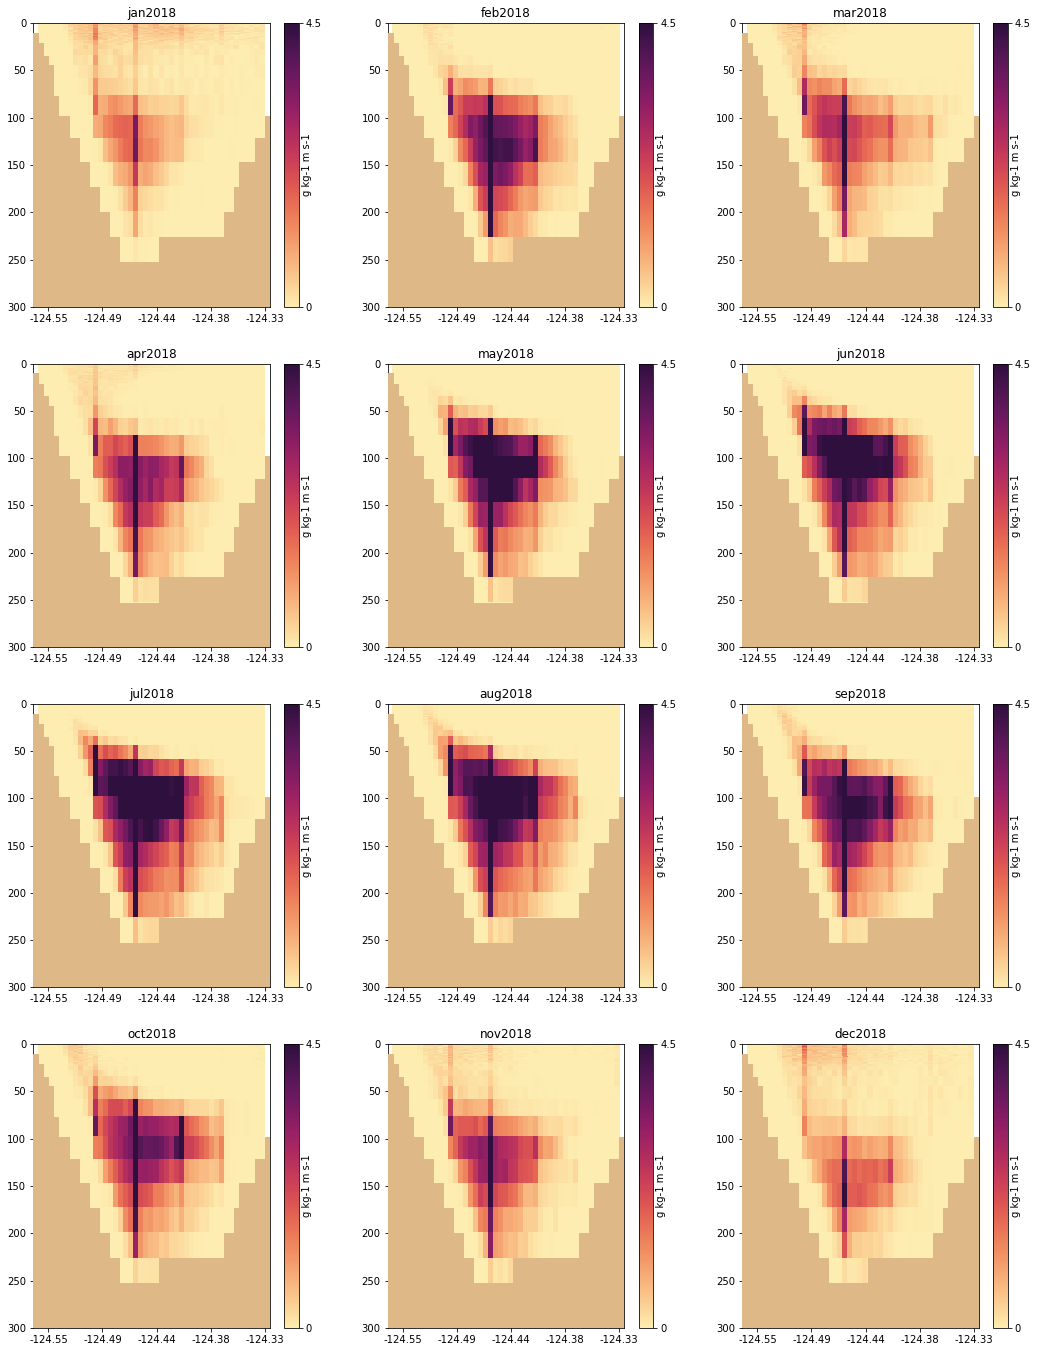

In [10]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    JRTracerFluxCS('silicon', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

## for 1 summer and 1 winter month plot JR CS flux seperately for each channel the water parcels end up in
i think January looks good as a winter "transient" flow and May looks good as an almost entirely "estuarine"

In [11]:
lonW, lonE, figrid, maxdepth = 18, 63, 377, 300
sections = [2,3,4,5,6] # admiralty, deception, rosario, san juan, haro
section_name = ['admiralty', 'deception', 'rosario', 'san juan', 'haro']

def JR_to_channels(tracername, section, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section == section)]
    lats = mydata.init_lat[(mydata.final_section == section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section == section)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section == section)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section == section)]
        if tracername == 'salt':
            t_max = round(25 * 0.1,1)
            cmap = cm.haline
            units = 'g kg-1 m s-1'
        else:
            t_max = round(25 * 0.1,1)
            cmap = cm.matter
            units = 'mmol m-2 s-1'
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section == section)]
        if tracername == 'nitrate':
            t_max = round(15 * 0.1,1)
            cmap = cm.rain
            units = 'mmol m-2 s-1'
        else:
            t_max = round(1200 * 0.1,1)
            cmap = cm.turbid
            units = 'mmol m-2 s-1'
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

#### January

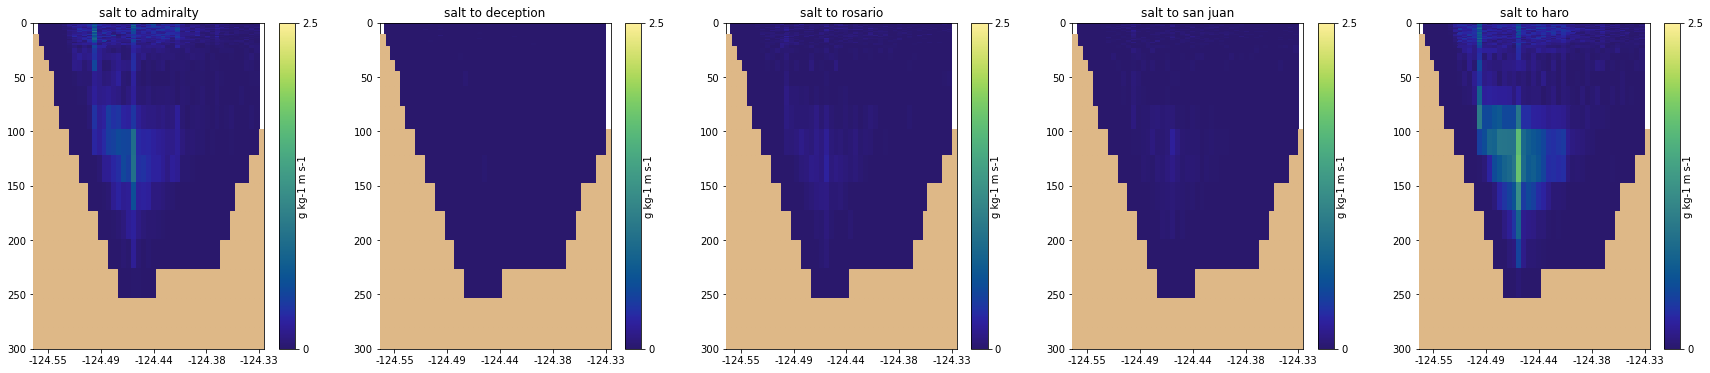

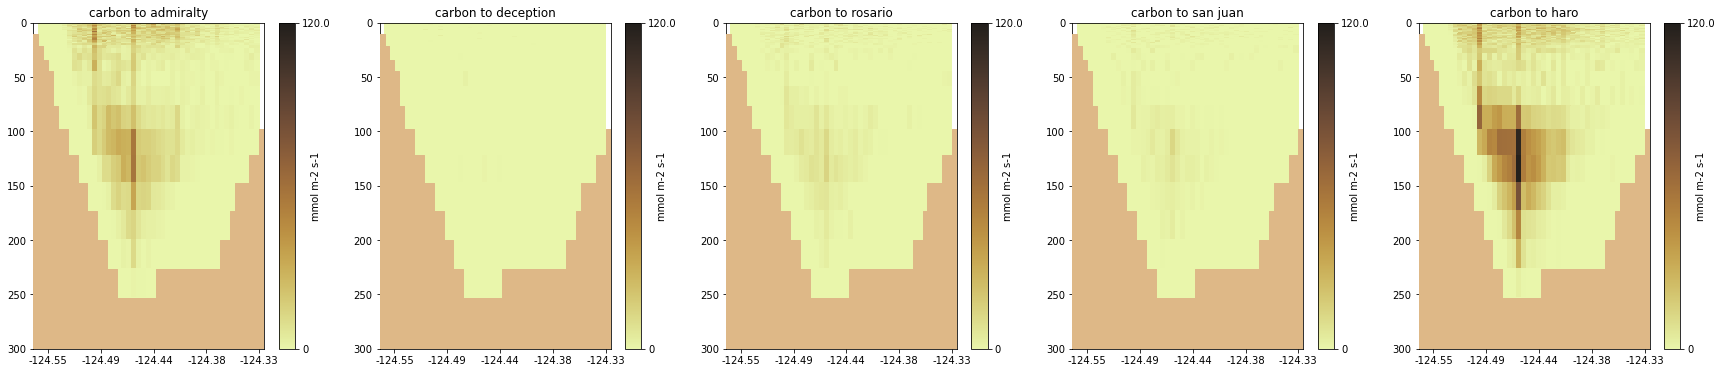

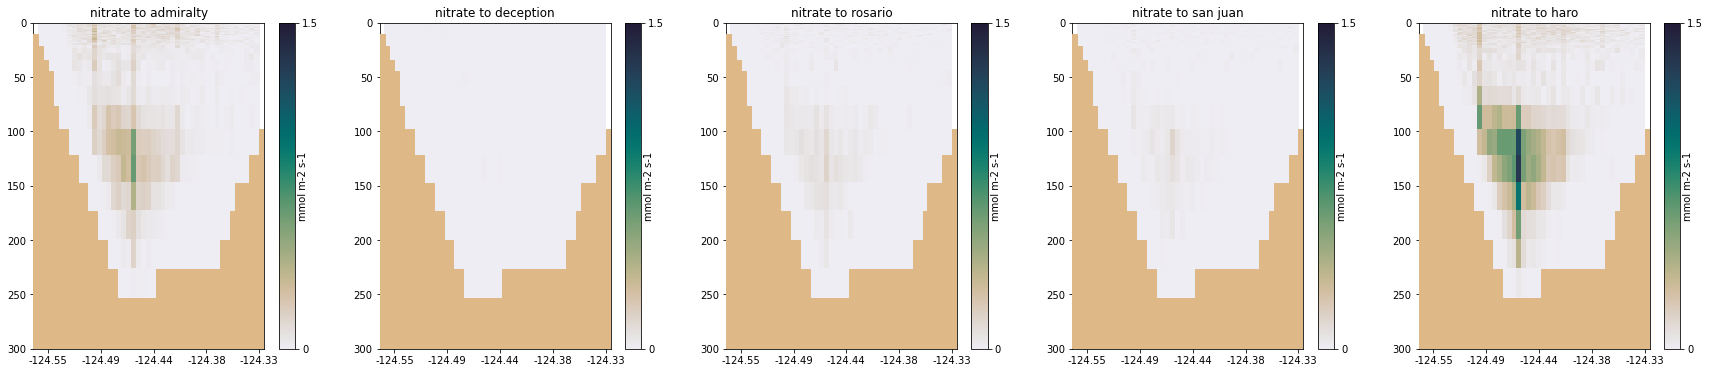

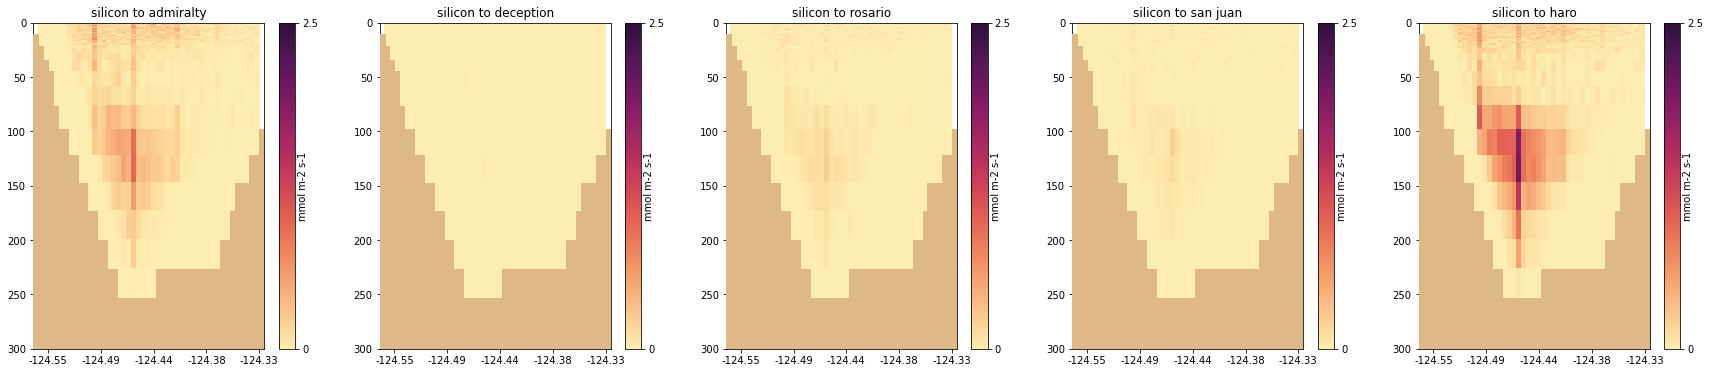

In [12]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'salt'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'carbon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'nitrate'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'silicon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])

### May

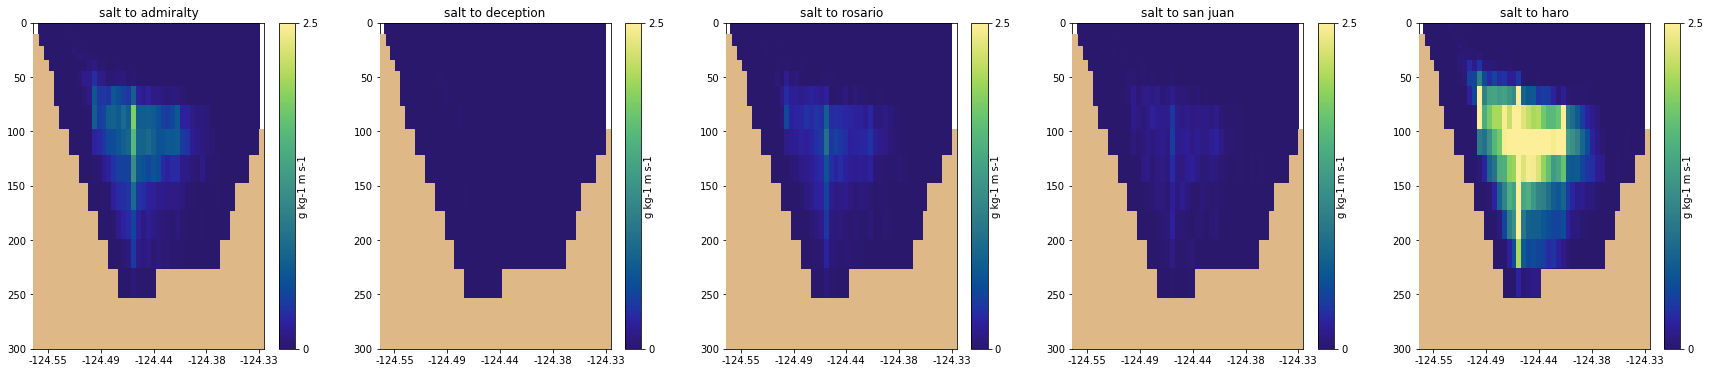

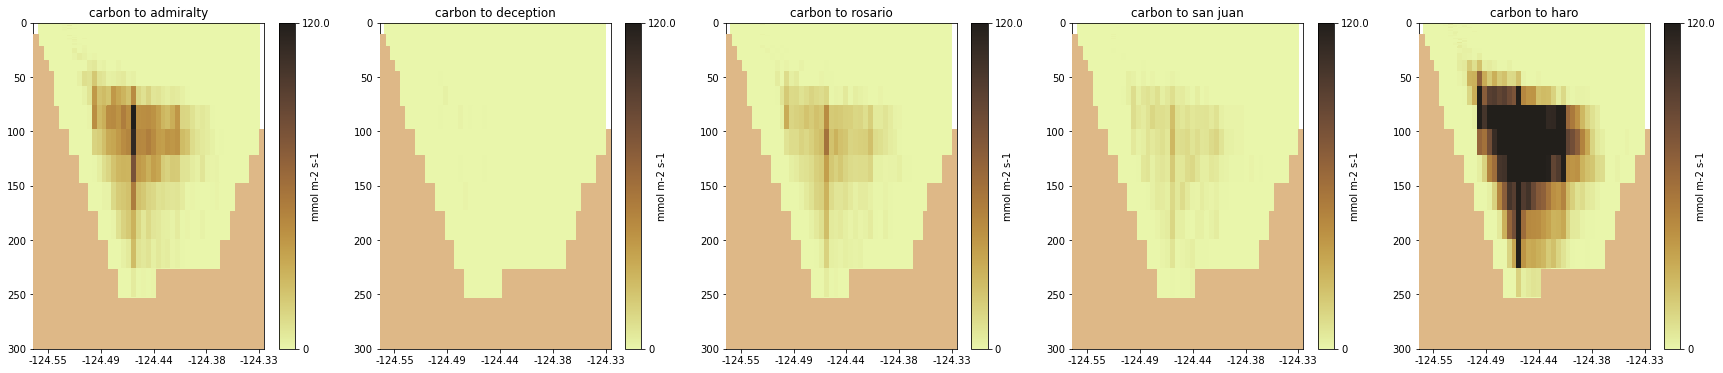

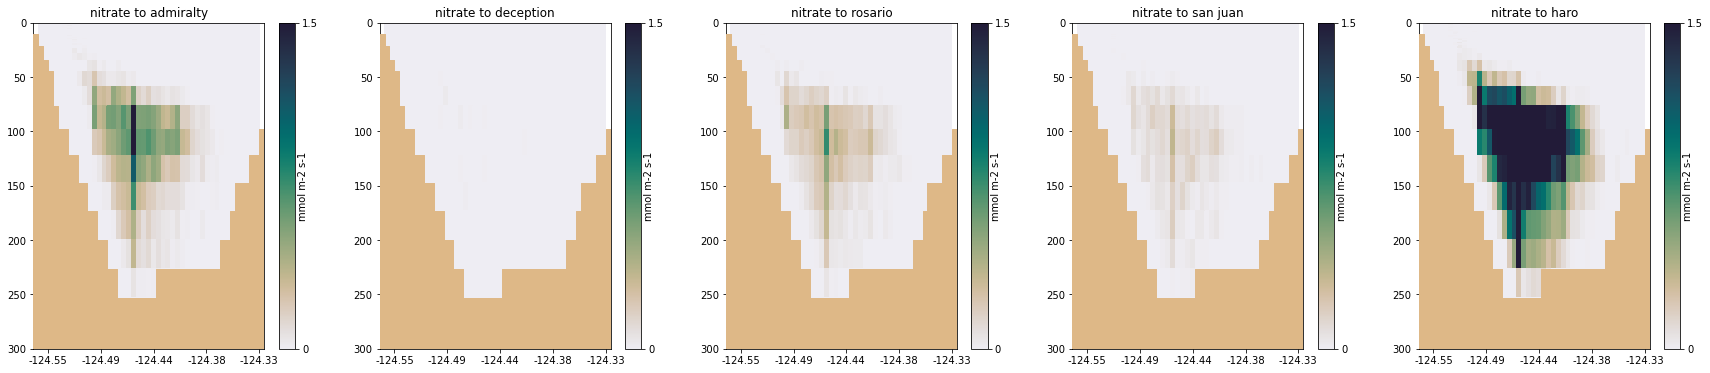

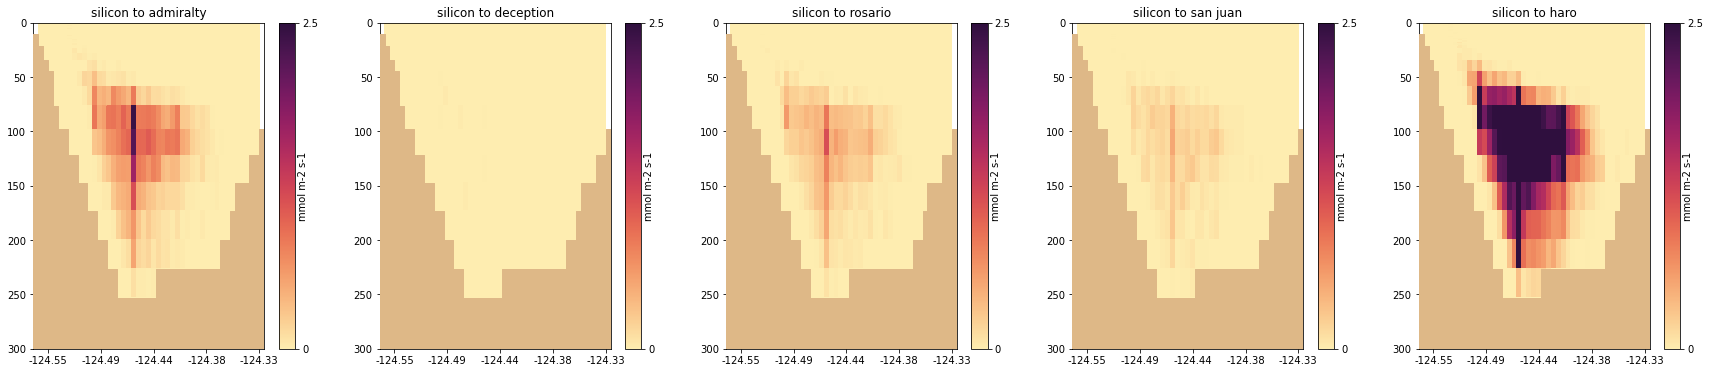

In [13]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'salt'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'carbon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'nitrate'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'silicon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])

### Now lets make a nice lil histogram to look at the composition of the water and how it changes

##### we want to do this for allllll the years though

In [30]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]

In [31]:
c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['2016','2017','2018','2019','2020']

In [68]:
def winter_months(variable):
    jan_start = 1
    mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
    oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
    dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
    
#     time = 720
    time1 = mar_end - jan_start +1
    time2 = dec_end - oct_start +1
    time = time1+ time2
    
    tracer = np.append(mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)],mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)])
    transport = np.append(mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]/time,mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]/time)
    depths = np.append(depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)]-1.)[0],depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)]-1.)[0])
    lons = np.append(mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= mar_end)],mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= oct_start) & (mydata.init_t <= dec_end)])
        
    return tracer, transport,lons, depths

In [69]:
def summer_months(variable):
    apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
    sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
    time = sep_end - apr_start +1
    
    tracer = mydata[variable][(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
    transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]/time
    depths = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]-1.)[0]
    lons = mydata.init_lon[(mydata.final_section != 0) & (mydata.init_t >= apr_start) & (mydata.init_t <= sep_end)]
        
    return tracer, transport,lons, depths

In [90]:
def winter_monthlies(variable, folder, yy): #not to be confused with winter_months - this is to do the same thimg but for runs done month by month
    time = 720
    months = ['jan', 'feb', 'mar','oct','nov', 'dec']
    files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+folder+'/forward_01'+month+str(yy)+'/ariane_positions_quantitative.nc' for month in months]
    tracer = []
    transport = []
    depths = []
    lons = []
    
    jan_start = 1
    mar_end = 720+(2*720+(sum(yearjumps[:3]*24)))
    oct_start = 1+(9*720+(sum(yearjumps[:10]*24)))
    dec_end = 720+(11*720+(sum(yearjumps[:12]*24)))
    time1 = mar_end - jan_start +1
    time2 = dec_end - oct_start +1
    time = time1+ time2

    for file in files:
        mydata = xr.open_dataset(file)
        tracer = np.append(tracer, mydata[variable][(mydata.final_section != 0)])
        transport = np.append(transport, mydata.init_transp[(mydata.final_section != 0)])
        depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0])
        lons = np.append(lons, mydata.init_lon[(mydata.final_section != 0)])
        
    return tracer, transport/time,lons, depths

In [88]:
    apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
    sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
    time = sep_end - apr_start +1

In [82]:
def summer_monthlies(variable, folder, yy): #not to be confused with summer_months - this is to do the same thimg but for runs done month by month
    time = 720
    months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
    files = ['/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+folder+'/forward_01'+month+str(yy)+'/ariane_positions_quantitative.nc' for month in months]
    tracer = []
    transport = []
    depths = []
    lons = []
    
    apr_start = 1+(3*720+(sum(yearjumps[:4]*24)))
    sep_end = 720+(8*720+(sum(yearjumps[:9]*24)))
    time = sep_end - apr_start +1

    for file in files:
        mydata = xr.open_dataset(file)
        tracer = np.append(tracer, mydata[variable][(mydata.final_section != 0)])
        transport = np.append(transport, mydata.init_transp[(mydata.final_section != 0)])
        depths = np.append(depths, depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0])
        lons = np.append(lons, mydata.init_lon[(mydata.final_section != 0)])
        
    return tracer, transport/time,lons, depths

In [91]:
#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, lonsW16, depthW16 = winter_months('init_salt')
tracerS16, transportS16, lonsS16, depthS16 = summer_months('init_salt')

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, lonsW17, depthW17 = winter_months('init_salt')
tracerS17, transportS17, lonsS17, depthS17 = summer_months('init_salt')

#2018
tracerW18, transportW18, lonsW18, depthW18 = winter_monthlies('init_salt', 'Car_Sal', 18)
tracerS18, transportS18, lonsS18, depthS18 = summer_monthlies('init_salt', 'Car_Sal', 18)

#2019
tracerW19, transportW19, lonsW19, depthW19 = winter_monthlies('init_salt', 'Car_Sal', 19)
tracerS19, transportS19, lonsS19, depthS19 = summer_monthlies('init_salt', 'Car_Sal', 19)

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, lonsW20, depthW20 = winter_months('init_salt')
tracerS20, transportS20, lonsS20, depthS20 = summer_months('init_salt')

In [50]:
figrid = 377
lonE = 63
lonW = 18

igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
time = 720

t_lons = mymesh.glamt[0, igrid]
m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
t_dist = t_lons/m2lon
t_depths = mymesh.gdept_1d[0,:]

xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))

summax = sum([sum(transportW16),sum(transportW17),sum(transportW18),sum(transportW19),sum(transportW20)])/5
vmax = .12/summax

distW16 = lonsW16/m2lon.values
H16, xedges, yedges = np.histogram2d(distW16, depthW16, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transportW16, density= True)

distW17 = lonsW17/m2lon.values
H17, _, _ = np.histogram2d(distW17, depthW17, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transportW17, density= True)

distW18 = lonsW18/m2lon.values
H18, _, _ = np.histogram2d(distW18, depthW18, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transportW18, density= True)

distW19 = lonsW19/m2lon.values
H19, _, _ = np.histogram2d(distW19, depthW19, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transportW19, density= True)

distW20 = lonsW20/m2lon.values
H20, _, _ = np.histogram2d(distW20, depthW20, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transportW20, density= True)

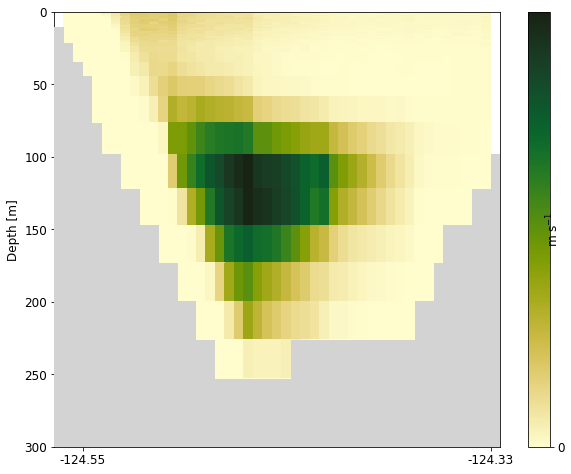

In [51]:
H=((H20+H19+H18+H17+H16)/5)
h= H
h[11,:] = H[11,:]/2.2
h[19,:] = H[19,:]/2.3
h[28,:] = H[28,:]/2
h[36,:] = H[36,:]/2

fig, ax = plt.subplots(1,1,figsize=(10,8))
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, h.T, vmin = 0, cmap=cm.speed)
    
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, np.round(((vmax * summax)),2)]) 
cb1.set_label('m s$^{-1}$', labelpad=-20)
    
pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
ax.add_collection(pc)

ax.invert_yaxis()
ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
ax.set_ylabel('Depth [m]')
ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
ax.set_ylim((300, 0))
# ax.set_title(str(title))
mydata.close()

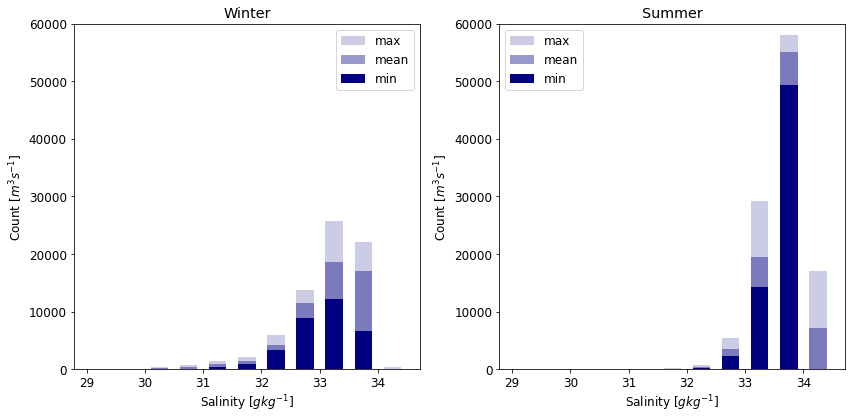

In [95]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
plt.rcParams['font.size'] = 12

#plt winter
jan_sal,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=np.arange(29,35,0.5), weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_sal,axis=0)
mini = np.min(jan_sal,axis=0)
maxi = np.max(jan_sal,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0].set_title('Winter')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_xlabel('Salinity [$g kg^{-1}$]')
ax[0].set_ylim([0,60000])
ax[0].legend()

#plt may
may_sal,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=np.arange(29,35,0.5), weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_sal,axis=0)
mini = np.min(may_sal,axis=0)
maxi = np.max(may_sal,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[1].set_title('Summer')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_xlabel('Salinity [$g kg^{-1}$]')
ax[1].set_ylim([0,60000])
ax[1].legend()

plt.tight_layout()

In [96]:
#CARBON
bins = np.arange(2000,2350,25)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, _, _ = winter_months('init_temp')
tracerS16, transportS16, _, _ = summer_months('init_temp')

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, _, _ = winter_months('init_temp')
tracerS17, transportS17, _, _ = summer_months('init_temp')

#2018
tracerW18, transportW18, _, _ = winter_monthlies('init_temp', 'Car_Sal', 18)
tracerS18, transportS18, _, _ = summer_monthlies('init_temp', 'Car_Sal', 18)

#2019
tracerW19, transportW19, _, _ = winter_monthlies('init_temp', 'Car_Sal', 19)
tracerS19, transportS19, _, _ = summer_monthlies('init_temp', 'Car_Sal', 19)

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, _, _ = winter_months('init_temp')
tracerS20, transportS20, _, _ = summer_months('init_temp')

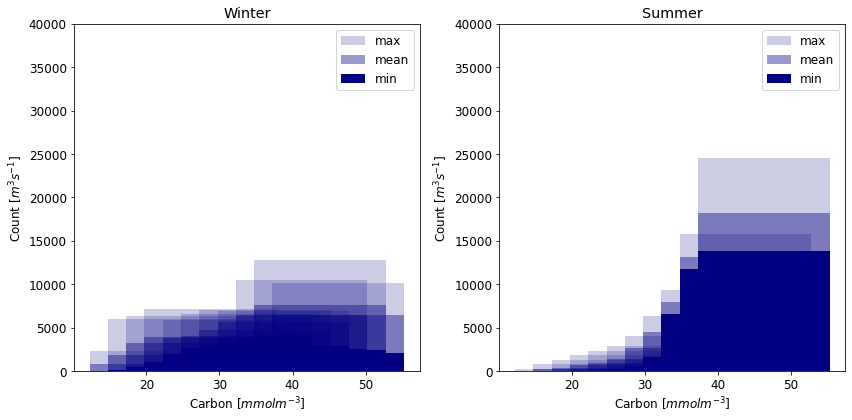

In [102]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

#plt winter
jan_car,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_car,axis=0)
mini = np.min(jan_car,axis=0)
maxi = np.max(jan_car,axis=0)

ax[0].bar(bin_centers,maxi,width=18, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=18, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=18, color='navy',label='min')

ax[0].set_title('Winter')
ax[0].set_xlabel('Carbon [$mmol m^{-3}$]')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_ylim([0,40000])
ax[0].legend()

#plt may
may_car,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_car,axis=0)
mini = np.min(may_car,axis=0)
maxi = np.max(may_car,axis=0)

ax[1].bar(bin_centers,maxi,width=18, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=18, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=18, color='navy',label='min')

ax[1].set_title('Summer')
ax[1].set_xlabel('Carbon [$mmol m^{-3}$]')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_ylim([0,40000])
ax[1].legend()

plt.tight_layout()

In [98]:
#NITRATE
bins = np.arange(5,35,2.5)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, _, _ = winter_months('init_temp')
tracerS16, transportS16, _, _ = summer_months('init_temp')

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, _, _ = winter_months('init_temp')
tracerS17, transportS17, _, _ = summer_months('init_temp')

#2018
tracerW18, transportW18, _, _ = winter_monthlies('init_temp', 'Nit_Sil', 18)
tracerS18, transportS18, _, _ = summer_monthlies('init_temp', 'Nit_Sil', 18)

#2019
tracerW19, transportW19, _, _ = winter_monthlies('init_temp', 'Nit_Sil', 19)
tracerS19, transportS19, _, _ = summer_monthlies('init_temp', 'Nit_Sil', 19)

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, _, _ = winter_months('init_temp')
tracerS20, transportS20, _, _ = summer_months('init_temp')

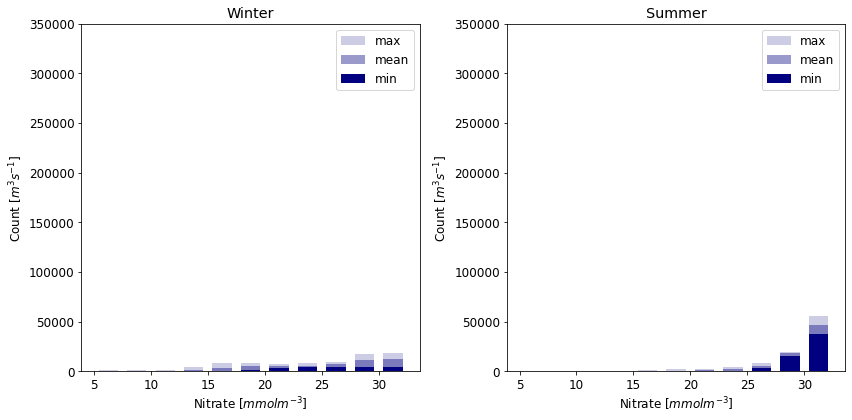

In [99]:

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

#plt winter
jan_nit,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_nit,axis=0)
mini = np.min(jan_nit,axis=0)
maxi = np.max(jan_nit,axis=0)

ax[0].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=1.7, color='navy',label='min')

ax[0].set_title('Winter')
ax[0].set_xlabel('Nitrate [$mmol m^{-3}$]')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_ylim([0,350000])
ax[0].legend()

#plt may
may_nit,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_nit,axis=0)
mini = np.min(may_nit,axis=0)
maxi = np.max(may_nit,axis=0)

ax[1].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=1.7, color='navy',label='min')

ax[1].set_title('Summer')
ax[1].set_xlabel('Nitrate [$mmol m^{-3}$]')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_ylim([0,350000])
ax[1].legend()

plt.tight_layout()

In [100]:
#SILICON
bins = np.arange(20,50,2.5)
time=720

#get all the data
#2016
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW16, transportW16, _, _ = winter_months('init_salt')
tracerS16, transportS16, _, _ = summer_months('init_salt')

#2017
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW17, transportW17, _, _ = winter_months('init_salt')
tracerS17, transportS17, _, _ = summer_months('init_salt')

#2018
tracerW18, transportW18, _, _ = winter_monthlies('init_salt', 'Nit_Sil', 18)
tracerS18, transportS18, _, _ = summer_monthlies('init_salt', 'Nit_Sil', 18)

#2019
tracerW19, transportW19, _, _ = winter_monthlies('init_salt', 'Nit_Sil', 19)
tracerS19, transportS19, _, _ = summer_monthlies('init_salt', 'Nit_Sil', 19)

#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerW20, transportW20, _, _ = winter_months('init_salt')
tracerS20, transportS20, _, _ = summer_months('init_salt')

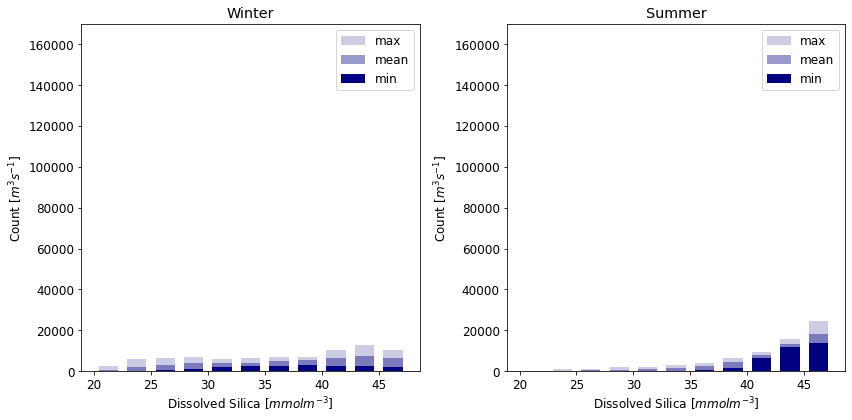

In [101]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

#plt winter
jan_sil,x,_ = ax[0].hist([tracerW16,tracerW17,tracerW18,tracerW19,tracerW20], bins=bins, weights= [transportW16,transportW17,transportW18,transportW19,transportW20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(jan_sil,axis=0)
mini = np.min(jan_sil,axis=0)
maxi = np.max(jan_sil,axis=0)

ax[0].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width=1.7, color='navy',label='min')

ax[0].set_title('Winter')
ax[0].set_xlabel('Dissolved Silica [$mmol m^{-3}$]')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_ylim([0,170000])
ax[0].legend()

#plt may
may_sil,x,_ = ax[1].hist([tracerS16,tracerS17,tracerS18,tracerS19,tracerS20], bins=bins, weights= [transportS16,transportS17,transportS18,transportS19,transportS20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(may_sil,axis=0)
mini = np.min(may_sil,axis=0)
maxi = np.max(may_sil,axis=0)

ax[1].bar(bin_centers,maxi,width=1.7, color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width=1.7, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width=1.7, color='navy',label='min')

ax[1].set_title('Summer')
ax[1].set_xlabel('Dissolved Silica [$mmol m^{-3}$]')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_ylim([0,170000])
ax[1].legend()

plt.tight_layout()

### curious about what delta CS plots would look like

In [76]:
def JRTracerFluxCS_delta(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    #ambient concentrations from "AmbientTracerConc.ipynb"
    amC = 2104.4632427854353 #mmol/m3
    amSi = 37.46235074714988 #mmol/m3
    amSa = 31.417757428541577 #g/kg
    amN = 23.037677314276408 #mmol/m3
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'salt':
            t_max = 0.3
            units = 'g kg-1 m s-1'
            tracer -= amSa
        else:
            t_max = 1.1
            units = 'mmol m-2 s-1'
            tracer -= amSi
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'nitrate':
            t_max = 1
            units = 'mmol m-2 s-1'
            tracer -= amN
        else:
            t_max = 22            
            units = 'mmol m-2 s-1'
            tracer -= amC
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    
    h= H_final
    h[:,11] = H_final[:,11]/2.6
    h[:,19] = H_final[:,19]/2.5
    h[:,28] = H_final[:,28]/2
    h[:,36] = H_final[:,36]/2

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.balance
    im = ax.pcolormesh(X, Y, h, vmax = t_max, vmin = -t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([-t_max, t_max])
    cb1.set_ticklabels([-t_max, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.set_ylabel('Depth [m]')
    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [75]:
def JRTracerFluxCS_delta_fullW(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    #ambient concentrations from "AmbientTracerConc.ipynb"
    amC = 2104.4632427854353 #mmol/m3
    amSi = 37.46235074714988 #mmol/m3
    amSa = 31.417757428541577 #g/kg
    amN = 23.037677314276408 #mmol/m3
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'salt':
            t_max = 0.07
            units = 'g kg-1 m s-1'
            tracer -= amSa
        else:
            t_max = 0.3
            units = 'mmol m-2 s-1'
            tracer -= amSi
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'nitrate':
            t_max = 0.3
            units = 'mmol m-2 s-1'
            tracer -= amN
        else:
            t_max = 5            
            units = 'mmol m-2 s-1'
            tracer -= amC
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    
    h= H_final
    h[:,11] = H_final[:,11]/2.6
    h[:,19] = H_final[:,19]/2.5
    h[:,28] = H_final[:,28]/2
    h[:,36] = H_final[:,36]/2

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.curl
    im = ax.pcolormesh(X, Y, h, vmax = t_max, vmin = -t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([-t_max, t_max])
    cb1.set_ticklabels([-t_max, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.set_ylabel('Depth [m]')
    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW+1], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW+1], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

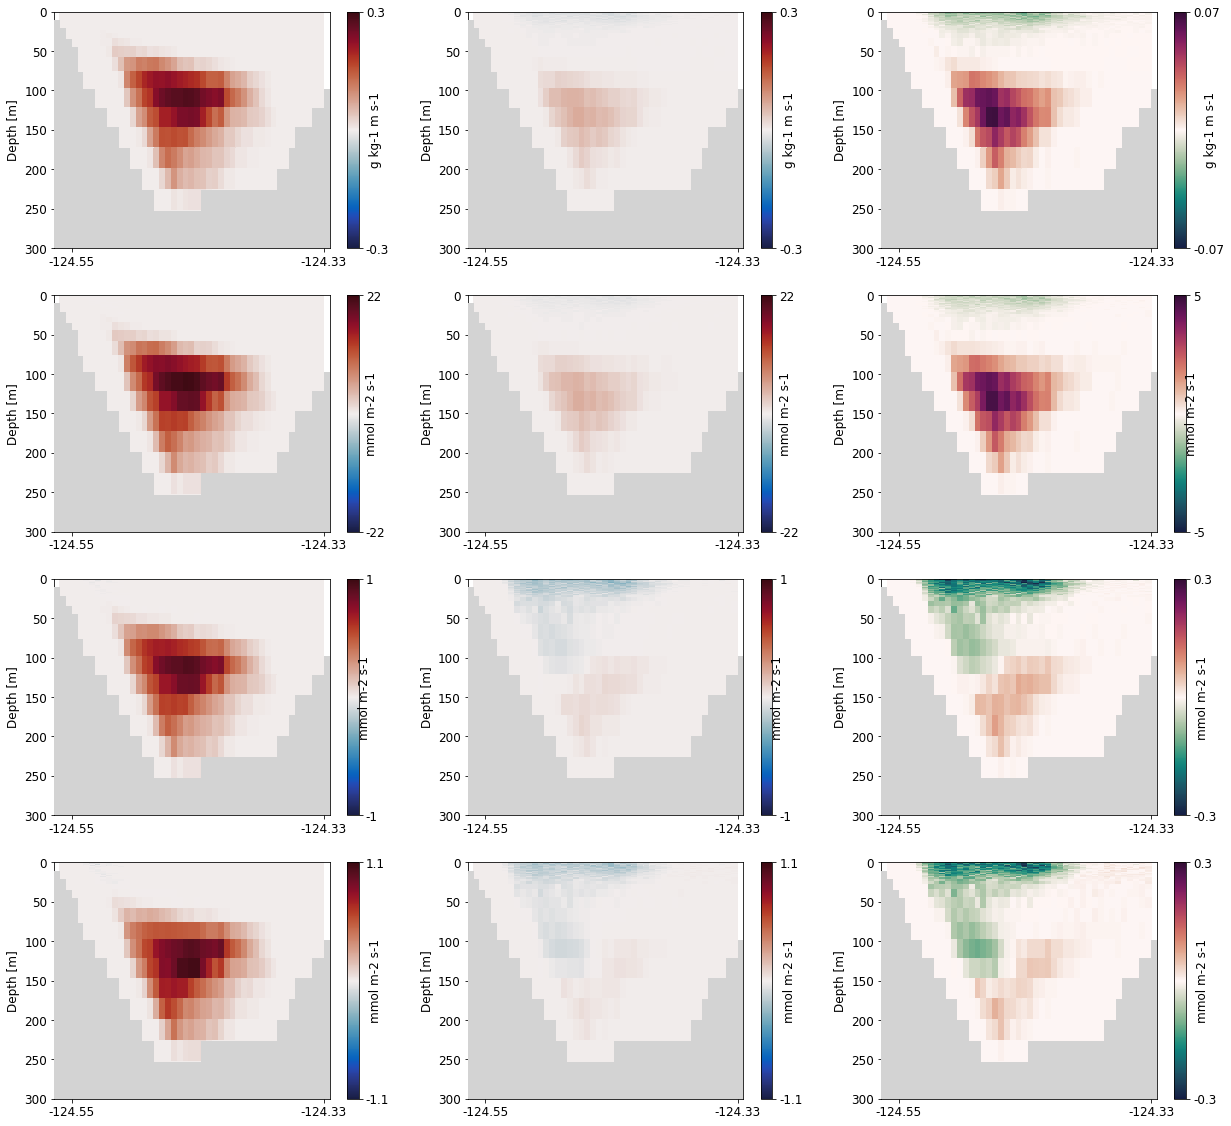

In [77]:
# now plt january and may for all four tracers
str_mo = ['may', 'jan']
fig, ax = plt.subplots(4, 3, figsize = (21, 20))
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)

    tracername = 'salt'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[0,i], str_mo[i]+": "+tracername)

    tracername = 'carbon'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[1,i], str_mo[i]+": "+tracername)

    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)

    tracername = 'nitrate'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[2,i], str_mo[i]+": "+tracername)

    tracername = 'silicon'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[3,i], str_mo[i]+": "+tracername)
    

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRTracerFluxCS_delta_fullW('salt', 18, 63, 377, 300, ax[0,2], 'bloop')
JRTracerFluxCS_delta_fullW('carbon', 18, 63, 377, 300, ax[1,2], 'bleep')
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
JRTracerFluxCS_delta_fullW('nitrate', 18, 63, 377, 300, ax[2,2], 'blaap')
JRTracerFluxCS_delta_fullW('silicon', 18, 63, 377, 300, ax[3,2], 'bliip')